# Neuron circuits for Dorsophila
Kai Yang, Tielin Zhang

Contains three groups of neurons:

(1) Pn group;

(2) Kc group;

(3) APL group;

In [37]:
from brian2 import *
import random
import pandas as pd
%matplotlib inline
apl_enable = True
Prob_Connection_p_pn = 1 # change to 0.1, 0.5, as probability.
start_scope()

### Test the single small loop

In [38]:
tau = 5*ms
Vth = -45*mV
Vres = -80*mV
I = 0*mV/ms

V0_1 = 0*mV
eqs1 = '''
dv/dt = (V0_1-v)/tau + I: volt
'''
G1 = NeuronGroup(1, eqs1, threshold='v>Vth', reset='v=Vres', refractory=1*ms, method='linear') #method='Euler' linear
G1.v = -60*mV # initial value

V0_2 = -60*mV
eqs2 = '''
dv/dt = (V0_2-v)/tau + I: volt
'''

G2 = NeuronGroup(1, eqs2, threshold='v>Vth', reset='v=Vres', refractory=1*ms, method='linear') #method='Euler' linear
G2.v = -60*mV # initial value

S = Synapses(G1, G2, 'w : volt', on_pre='v_post += w')
S.connect() # connect all-to-all
S.w = '0.1*mV'

debug = False
if debug:
    M1 = StateMonitor(G1, 'v', record=0)
    M2 = StateMonitor(G2, 'v', record=0)
    M3 = StateMonitor(S,'w',record=0)
    run(50*ms)

    figure()
    subplot(311)
    plot(M1.t/ms, M1.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    subplot(312)
    plot(M2.t/ms, M2.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    subplot(313)
    plot(M3.t/ms, M3.w[0])
    xlabel('Time (ms)')
    ylabel('w');

### The possion input generator

In [39]:
inputnum = 10
Poisson = PoissonGroup(inputnum, 100*Hz)

## PN Group (100-200 neurons)

A PN is modeled as the standard leaky integrate and fire (LIF) neuron. The membrane potential of a PN at time t is determined by the following differential equation, $\frac{dV}{dt} = \frac{(V0−V)}{\tau}+ I$, where $\tau$ is the membrane time constant and V0 is the resting potential. When the membrane potential of a PN exceeds the threshold value Vth, the PN emits a spike and the value of the membrane potential is reset to Vreset. After the spike emission, the PN enters an absolute refractory period that lasts for Vres. The membrane potential of a PN stays at Vres during the refractory period. The parameters in the leaky integrate-and-fire neuron model are set as follows: tau=5 ms,V0=−60mV,Vth=−45mV, Vreset=−60mV,and Vres =10ms.

In [40]:
num_pn = 144
tau_pn = 5*ms
V0_pn = -60*mV
Vth_pn = -45*mV
Vres_pn = -60*mV
I_pn = 0*mV/ms
eqs_pn = '''
dv/dt = (V0_pn-v)/tau_pn + I_pn: volt
'''
G_pn = NeuronGroup(num_pn, eqs_pn, threshold='v>Vth_pn', reset='v=Vres_pn', refractory=4*ms, method='linear') #method='Euler' linear
G_pn.v = -60*mV # initial value

## KC Group (around 2500 neurons)

Here we use the similar LIF model for simplification.


In [41]:
num_kc = 250
tau_kc = 5*ms
V0_kc = -60*mV
Vth_kc = -36*mV
Vres_kc = -60*mV
eqs_kc = '''
dv/dt = (V0_kc-v)/tau_kc : volt
'''
G_kc = NeuronGroup(num_kc, eqs_kc, threshold='v>Vth_kc', reset='v=Vres_kc', refractory=1*ms, method='Euler') #method='Euler' linear
G_kc.v = -60*mV # initial value

### APL Group (one neuron)

In [42]:
C = 0.1*nF
g_leak = 0.2*uS
V_leak = -60*mV
g_aplkc = 50*nS
V_rev = -90*mV
V_mid = -40*mV
V_slope = 5*mV
tau_apl = 4*ms
V_pre = 2*mV
eqs_apl = '''
S_inf = 1/(1+exp((V_mid - V_pre)/V_slope)): 1
dS/dt = (S_inf - S)/tau_apl : 1
I_input = g_aplkc * S*(v-V_rev) : amp
dv/dt =(I_input - g_leak*(v - V_leak))/ C : volt
'''
G_apl = NeuronGroup(1, eqs_apl,threshold='v>V_mid', reset='v=V_rev', refractory=1*ms, method='Euler') #method='Euler' linear
G_apl.v = -60*mV # initial value
# Because the apl equations contains the description of APL to KC synapse, so I disabled the APL-KC synapse below.

old code
```
tau_apl = 5*ms
V0_apl = -60*mV  # attractors
Vth_apl = -45*mV
Vres_apl = -60*mV 
eqs_apl = '''
dv/dt = (V0_apl-v)/tau_apl : volt
'''
G_apl = NeuronGroup(1, eqs_apl, threshold='v>Vth_apl', reset='v=Vres_apl', refractory=1*ms, method='Euler') #method='Euler' linear
G_apl.v = -60*mV # initial value
```

### Connection between input Possion to PN

In [43]:
S_p_pn = Synapses(Poisson, G_pn, 'w : volt', on_pre='v_post += w')
S_p_pn.connect(p=Prob_Connection_p_pn) # connect all-to-all, p == the probability of connection, CHANGE HERE 
S_p_pn.w = '5*mV'

### Connection between PN to KC

(1) PN->KC, each KC neuron accept mean 6 PN Axonal Terminal, 

(2) Big PN Axonal terminal to 20 KC neuron, 

(3) Small PN Axonal terminal to 8 KC neuron,

You cannot fit both of these three conditions.!!

In [44]:
S_pn_kc = Synapses(G_pn, G_kc, 'w : volt', on_pre='v_post += w')

propertion = 0.6 # the big Pn proportion in source group
bigPn = np.arange( 0, int(propertion*G_pn.N), 1) 
smallPn = np.arange( int(propertion*G_pn.N), G_pn.N, 1) 

arrayi = []
arrayj = []

for i in range(G_pn.N):
    if i in bigPn:
        ifrom = [i]*15
        random.seed(1)
        ito = [random.randint(0,G_kc.N-1) for _ in range(15)]
    else:
        ifrom = [i]*12
        random.seed(1)
        ito = [random.randint(0,G_kc.N-1) for _ in range(12)]
    arrayi.extend(ifrom)
    arrayj.extend(ito)
# arrayi = [int(i) for i in arrayi]
# arrayj = [int(j) for j in arrayj]
S_pn_kc.connect(i=arrayi, j=arrayj)
S_pn_kc.w = '10*mV'

### Calculation: How many mean input numbers of the each KC gets.

In [45]:
print('The mean inputs of KC neuron is : '+ str(len(S_pn_kc.i)/G_kc.N))

The mean inputs of KC neuron is : 7.944


### Connection KC >> APL

In [46]:
S_kc_apl = Synapses(G_kc, G_apl, 'w : volt', on_pre='v_post += w')
S_kc_apl.connect() # connect all-to-all
if apl_enable:
    S_kc_apl.w = '5*mV'
else:
    S_kc_apl.w = '0*mV'

### Connection APL >> KC

old code
```python
S_apl_kc = Synapses(G_apl, G_kc, 'w : volt', on_pre='v_post += w')
S_apl_kc.connect() # connect all-to-all
if apl_enable:
    S_apl_kc.w = '-1*mV'
else:
    S_apl_kc.w = '0*mV'
``` 

### Connection APL >> PN

In [47]:
S_apl_pn = Synapses(G_apl, G_pn, 'w : volt', on_pre='v_post += w')
S_apl_pn.connect() # connect all-to-all
for j in range(G_pn.N):
    if apl_enable:
        if j in bigPn:
            S_apl_pn.w[0,j] = '-5*mV'
        else:
            S_apl_pn.w[0,j] = '-1*mV'
    else:
        S_apl_pn.w[0,j] = '0*mV'

14
13


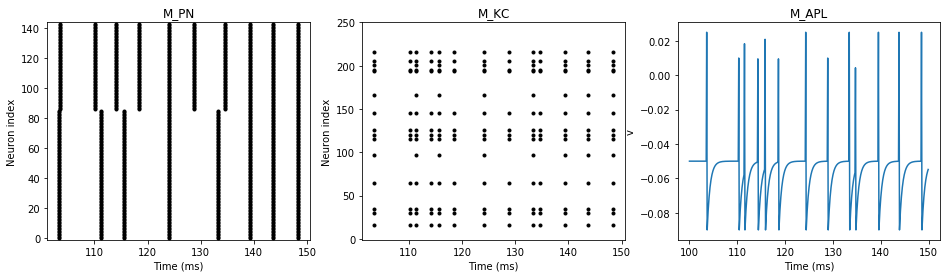

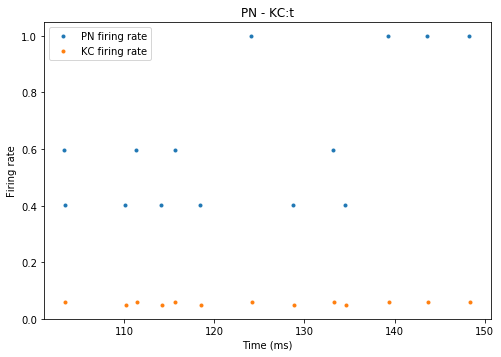

In [51]:
debug = True
if debug:
    M_pn = SpikeMonitor(G_pn)
    M_kc = SpikeMonitor(G_kc)
    M_apl = StateMonitor(G_apl, 'v', record=0)
    duration = 50*ms
    run(duration)
    
   
    figure(figsize=(16,4))  
    subplot(131)
    plot(M_pn.t/ms, M_pn.i, '.k')
    #print(len(set(M_pn.t/ms)))
    xlabel('Time (ms)')
    ylabel('Neuron index');
    ylim(-1, G_pn.N)
    title('M_PN')
    
    subplot(132)
    plot(M_kc.t/ms, M_kc.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    ylim(-1, G_kc.N)
    title('M_KC')
    #print(len(set(M_kc.t/ms)))
    subplot(133)
    plot(M_apl.t/ms, M_apl.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_APL')
    
    figure(figsize=(8,12))
    subplot(211)
    M_pn_ct = pd.value_counts(M_pn.t/ms, sort=False)
    M_pn_time = sort(M_pn_ct.index)
    M_pn_fr = M_pn_ct[M_pn_time]/num_pn
    
    M_kc_ct = pd.value_counts(M_kc.t/ms, sort=False)
    M_kc_time = sort(M_kc_ct.index)
    M_kc_fr = M_kc_ct[M_kc_time]/num_kc
    
    plot(M_pn_time, M_pn_fr,'.',label='PN firing rate')
    plot(M_kc_time, M_kc_fr,'.',label='KC firing rate')
    
    xlabel('Time (ms)')
    ylabel('Firing rate');
    title('PN - KC:t')
    legend()
    
#     subplot(212)
#     plot(M_pn_fr,M_kc_fr,'.')
#     xlabel('PN Firing rate')
#     ylabel('KC Firing rate');
#     title(' PN - KC')

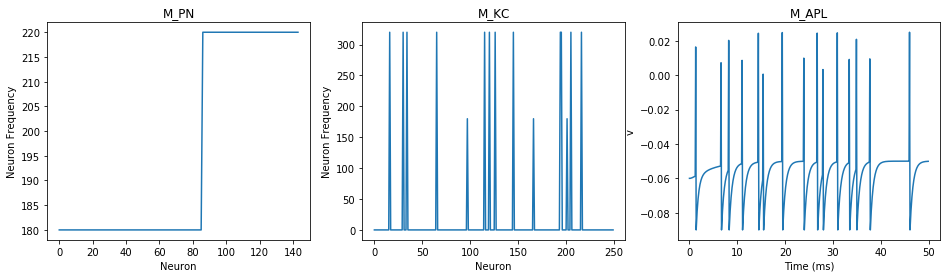

In [49]:
debug = True
if debug:
    figure(figsize=(16,4))
    subplot(131)
    plot(M_pn.count/duration)
    xlabel('Neuron')
    ylabel('Neuron Frequency');
    # ylim(-1, G_pn.N)
    title('M_PN')
    subplot(132)
    plot(M_kc.count/duration)
    xlabel('Neuron')
    ylabel('Neuron Frequency');
    # ylim(-1, G_kc.N)
    title('M_KC')
    subplot(133)
    plot(M_apl.t/ms, M_apl.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_APL')